In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
from sklearn import utils
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD
import tqdm

In [3]:
categories = ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'Inside_City', 'Kitchen', 'Livingroom', 'Mountain',
              'Office', 'Open_Country', 'Store', 'Street', 'Suburb', 'Tall_Building']

path = "/content/gdrive/MyDrive/Data/"

In [5]:
def augment_data(root):
    data, labels = [], []
    for path, subdirs, files in os.walk(root):
        for file in files:
            img = cv2.imread(path + '/' + file)
            img = cv2.resize(img, (224, 224))
            h, w, _ = np.shape(img)

            flipped_img = cv2.flip(img.copy(), 1)
            noisy_img = (random_noise(random_noise(img.copy(), mode='speckle'), mode='s&p',amount=0.02))
            # blurred_img = (random_noise(img.copy(), mode='gaussian', var=0.006))
            # warped_img = get_warped(img.copy(), h, w)
            # rot_img1 = get_rotated(img.copy(), 10, h, w)
            # rot_img2 = get_rotated(img.copy(), -10, h, w)

            cv2.imwrite(path + '/' + file, img)
            cv2.imwrrite(path + '/Aflipped_' + file, flipped_img)
            cv2.imwite(path + '/Anoisy_' + file, noisy_img * 255)
            # cv2.imwrite(path + '/Ablurred_' + file, blurred_img * 255)
            # cv2.imwrite(path + '/Awarped_' + file, warped_img)
            # cv2.imwrite(path + '/Arotated1_' + file, rot_img1)
            # cv2.imwrite(path + '/Arotated2_' + file, rot_img2)


def get_warped(img, h, w):
  src_pnts = np.float32([[int(w/15), int(h/15)],[w-int(w/15), int(h/15)], [0,h], [w,h]])
  dst_pnts = np.float32([[0,0],[w,0],[0,h],[w,h]])
  H = cv2.getPerspectiveTransform(src_pnts, dst_pnts)
  return cv2.warpPerspective(img, H, (w,h))


def get_rotated(img, theta, h, w):
  rot_mat = cv2.getRotationMatrix2D((h/2, w/2), 10, 1)
  return cv2.warpAffine(img, rot_mat, (w,h))

In [6]:
augment_data(path)

In [7]:
import pickle

def save(obj, file_name):
  f = open(file_name, 'wb')
  pickle.dump(obj, f)
  f.close()
  return

def read(file_name):
  f = open(file_name, 'rb')
  obj = pickle.load(f)
  f.close()
  return obj

In [8]:
def fit_model(epochs, model, optimizer, Train, Test):
    criterion = torch.nn.CrossEntropyLoss()

    train_acc1, train_acc5, train_loss = [], [], []
    test_acc1, test_acc5, test_loss = [], [], []

    for epoch in range(epochs):
        epoch_acc1, epoch_acc5, epoch_loss = 0, 0, 0
        model = model.train() 
        
        with tqdm.tqdm(enumerate(Train), total=len(Train)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                optimizer.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.detach().item()
                
                _, pred5 = output.data.topk(5, dim=1)
                _, pred1 = output.data.topk(1, dim=1)

                epoch_acc1 += (pred1.t() == labels).sum().item()
                for j, row in enumerate(labels):
                    if (row.item() in pred5[j]):
                        epoch_acc5 += 1

        train_loss.append(epoch_loss/(i+1))
        train_acc1.append(epoch_acc1/len(Train.dataset))
        train_acc5.append(epoch_acc5/len(Train.dataset))

        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc1/len(Train.dataset)))
        
        criterion = torch.nn.CrossEntropyLoss()
        epoch_acc1, epoch_acc5, epoch_loss = 0, 0, 0
        model.eval()  
        
        with tqdm.tqdm(enumerate(Test), total=len(Test)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = criterion(output, labels)

                epoch_loss += loss.detach().item()
                _, pred5 = output.data.topk(5, dim=1)
                _, pred1 = output.data.topk(1, dim=1)

                epoch_acc1 += (pred1.t() == labels).sum().item()
                for j,row in enumerate(labels):
                    if (row.item() in pred5[j]):
                        epoch_acc5+=1

        test_loss.append(epoch_loss/(i+1))
        test_acc1.append(epoch_acc1/len(Test.dataset))
        test_acc5.append(epoch_acc5/len(Test.dataset))

        print('Epoch: %d | Loss: %.4f | Test Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc1/len(Test.dataset)))

    return {'loss':train_loss, 'acc1':train_acc1, 'acc5':train_acc5}, {'loss':test_loss,'acc1':test_acc1,'acc5':test_acc5}

In [9]:
def plot(train_hist, test_hist, file_name):
    train_acc1, test_acc1 = train_hist['acc1'], test_hist['acc1']
    train_acc5, test_acc5 = train_hist['acc5'], test_hist['acc5']

    train_loss, test_loss = train_hist['loss'], test_hist['loss']

    fig=plt.figure(figsize=(25,5))
    plt.subplot(131)
    plt.plot(train_acc1, label='Train accuracy')
    plt.plot(test_acc1, label='Validation accuracy')
    plt.title('Accuracy for top1')
    plt.legend()
    
    plt.subplot(132)
    plt.plot(train_acc5, label='Train accuracy')
    plt.plot(test_acc5, label='Validation accuracy')
    plt.title('Accuracy for top5')
    plt.legend()

    plt.subplot(133)
    plt.plot(train_loss, label='Train loss')
    plt.plot(test_loss, label='Validation loss')
    plt.title('loss')
    plt.legend()

    plt.show()
    fig.savefig(file_name, dpi=4*fig.dpi)

In [10]:
transform = transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3]),
        ])

batch_size = 64

In [11]:
trainset = torchvision.datasets.ImageFolder(path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.ImageFolder(path, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [12]:
# network 1

model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
    nn.BatchNorm2d(96), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4, stride=4),
    nn.Dropout(p=0.5, inplace=True), 

    nn.AdaptiveAvgPool2d(output_size=(6, 6)),
    nn.Flatten(),
    
    nn.Linear(in_features=(6 * 6 * 96), out_features=4096),
    nn.ReLU(),
    nn.Linear(in_features=4096, out_features=len(categories)),
    )

In [ ]:
optimizer = SGD(model.parameters(), lr=0.008, momentum=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_res, test_res = fit_model(30, model, optimizer, trainloader, testloader)

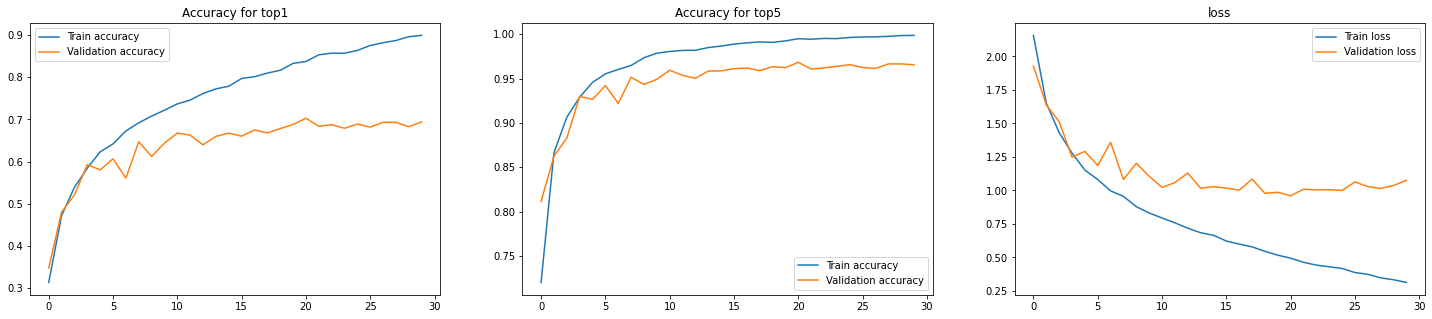

In [27]:
plot(train_res, test_res, 'network1.jpg')

In [14]:
# network 2

model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),  

    nn.Conv2d(96, 256, 5, padding=2),
    nn.BatchNorm2d(256), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Dropout(p=0.5),

    nn.Conv2d(256, 256, 3, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  
    
    nn.AdaptiveAvgPool2d(output_size=(6, 6)),
    nn.Flatten(),

    nn.Dropout(p=0.5),
    nn.Linear(in_features=9216, out_features=4096),
    nn.ReLU(),

    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    
    nn.Linear(in_features=4096, out_features=len(categories))
    )

In [ ]:
optimizer = SGD(model.parameters(), lr=0.002, momentum=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_res, test_res = fit_model(40, model, optimizer, trainloader, testloader)

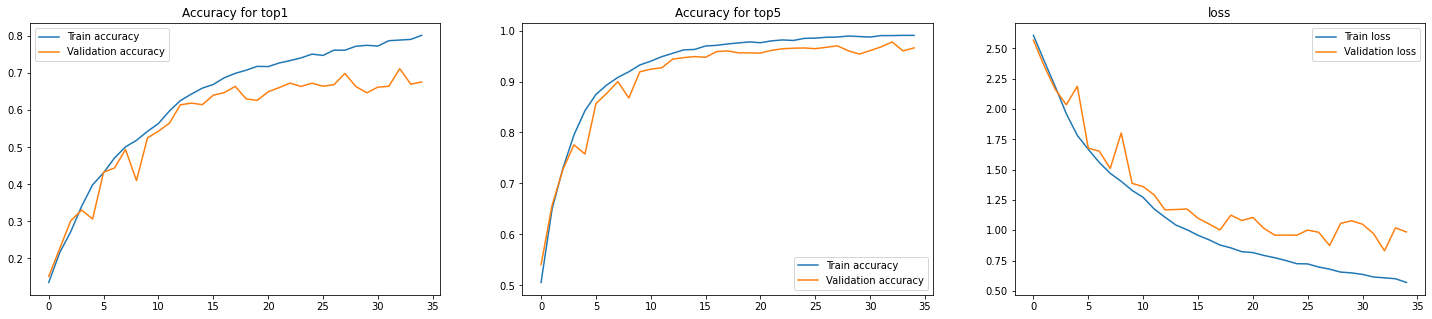

In [40]:
plot(train_res, test_res, 'network2.jpg')

In [16]:
# network 3

model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  
    nn.ReLU(),
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.7, k=2),  
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.BatchNorm2d(96),
    nn.Conv2d(96, 256, 5, padding=2),  
    nn.ReLU(),
    nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.7, k=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Dropout2d(p=0.5),

    nn.BatchNorm2d(256),
    nn.Conv2d(256, 384, 3,stride=2, padding=1),  
    nn.ReLU(),
    nn.Dropout2d(p=0.5),

    nn.BatchNorm2d(384),
    nn.Conv2d(384, 384, 3, padding=1),  
    nn.ReLU(),
    nn.Dropout2d(p=0.5),

    nn.Conv2d(384, 256, 3, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.AdaptiveAvgPool2d(output_size=(6, 6)),
    nn.Flatten(),

    nn.Dropout2d(p=0.5), 
    nn.Linear(in_features=9216, out_features=4096),
    nn.ReLU(),

    nn.Dropout2d(p=0.5), 
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    
    nn.Linear(in_features=4096, out_features=len(categories)),
    )

In [ ]:
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_res, test_res = fit_model(50, model, optimizer, trainloader, testloader)

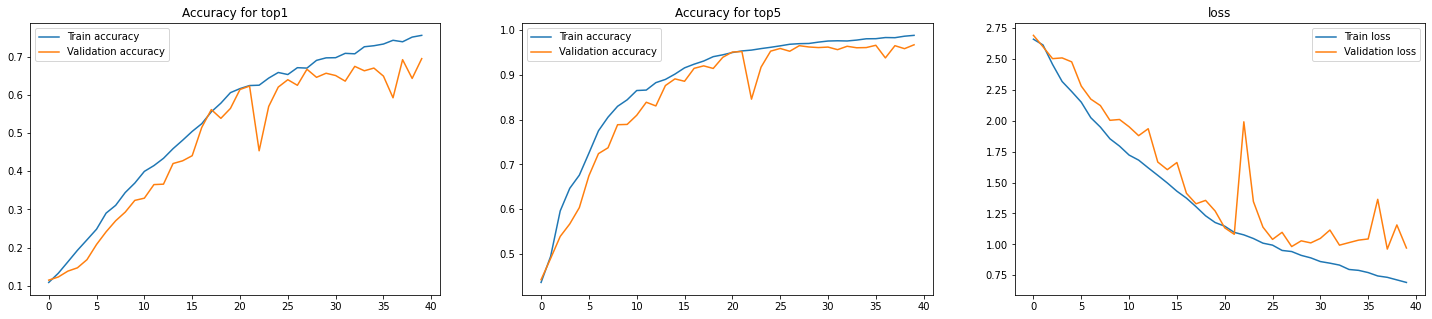

In [9]:
plot(train_res, test_res, 'network3.jpg')

In [18]:
from torchsummary import summary

# network 4

alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
alexnet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [20]:
for parameter in alexnet.parameters():
    parameter.requires_grad = False

alexnet.classifier[6] = torch.nn.Linear(in_features=4096, out_features=15, bias=True)
model = alexnet

In [ ]:
optimizer = SGD(model.parameters(), lr=0.002, momentum=0.8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_res, test_res = fit_model(40, model, optimizer, trainloader, testloader)

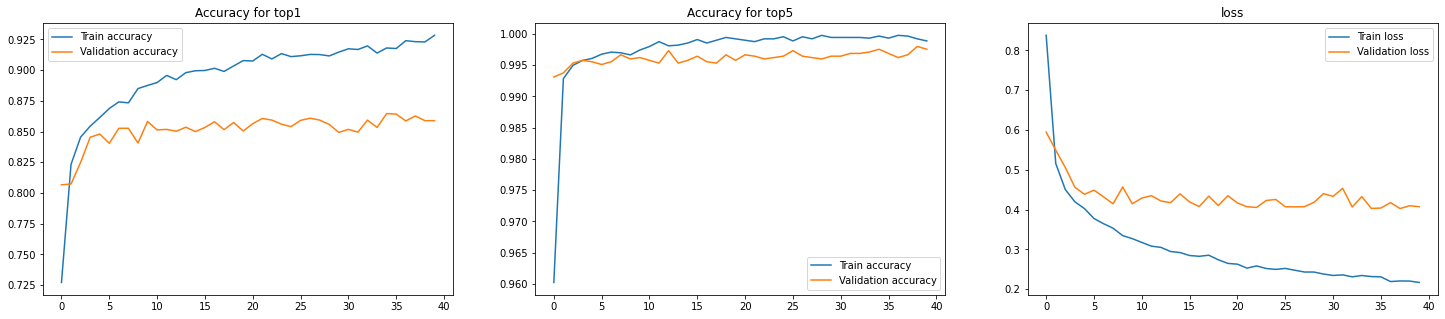

In [63]:
plot(train_res, test_res, 'network4.jpg')

In [ ]:
# network 5
 
alexnet = torchvision.models.alexnet(pretrained=True)

for param in alexnet.parameters():
    param.requires_grad = False

conv = list(alexnet.features.children())
fc = list(alexnet.classifier.children())
fc = fc[0:-1]
conv.append(torch.nn.Flatten())
conv.extend(fc)
layer = torch.nn.Linear(in_features=4096, out_features=15, bias=True)
conv.append(layer)
model = torch.nn.Sequential(*conv)

In [ ]:
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_res, test_res = fit_model(40, model, optimizer, trainloader, testloader)

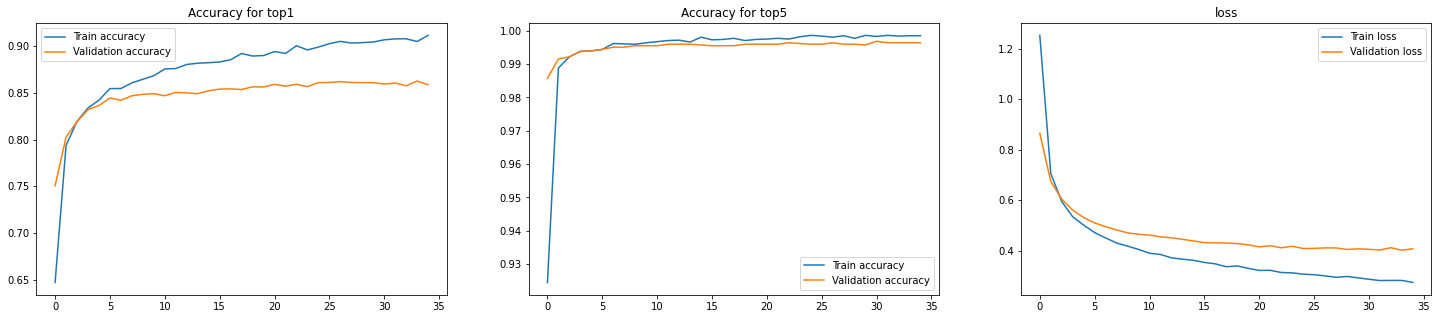

In [44]:
plot(train_res, test_res, 'network51.jpg')

In [24]:
for param in alexnet.parameters():
    param.requires_grad = True

In [ ]:
optimizer = SGD(model.parameters(), lr=0.0002, momentum=0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_res, test_res = fit_model(40, model, optimizer, trainloader, testloader)

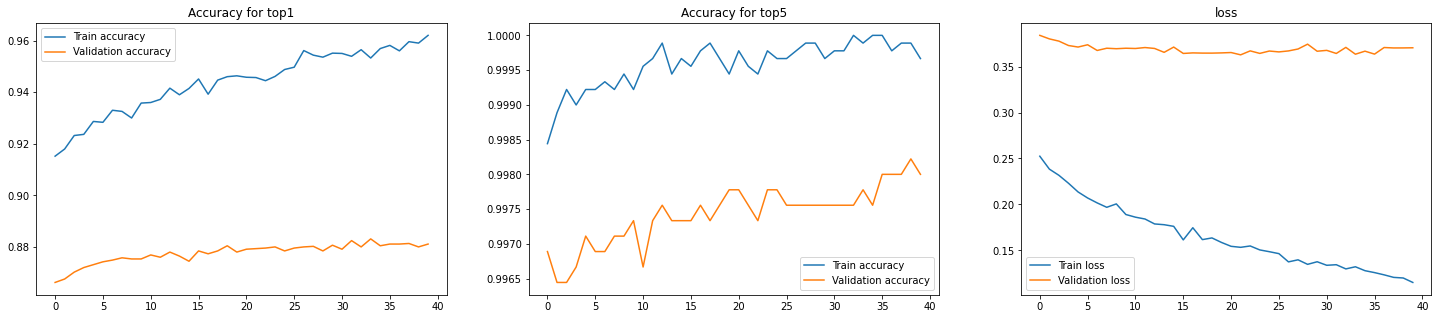

In [46]:
plot(train_res, test_res, 'network52.jpg')